In [1]:
# X-ray Fracture Detection using MobileNet and KNN

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2025-05-02 18:59:41.708240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746212381.948842      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746212382.017248      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define parameters
IMG_SIZE = 224  # MobileNet default input size
BATCH_SIZE = 32
RANDOM_STATE = 42

In [3]:
print("Step 1: Data Loading and Feature Extraction using MobileNet")

def load_dataset(data_dir, split_type):
    """
    Load the X-ray dataset that is already split into train/test sets.
    Expected structure:
    - data_dir/
        - train/
            - fractured/
                - image1.jpg
                - image2.jpg
            - not_fractured/
                - image1.jpg
                - image2.jpg
        - test/
            - fractured/
                - image1.jpg
                - image2.jpg
            - not_fractured/
                - image1.jpg
                - image2.jpg
    """
    images = []
    labels = []
    
    # Set path based on split type (train or test)
    split_path = os.path.join(data_dir, split_type)
    if not os.path.exists(split_path):
        print(f"Warning: {split_path} does not exist. Please check your dataset structure.")
        return np.array([]), np.array([])
    
    # Assuming binary classification with 'fractured' and 'not_fractured' folders
    categories = ['fractured', 'not fractured']
    
    for category_idx, category in enumerate(categories):
        path = os.path.join(split_path, category)
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist. Please check your dataset structure.")
            continue
            
        for img_name in tqdm(os.listdir(path), desc=f"Loading {split_type} {category} images"):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(path, img_name)
                try:
                    # Load and preprocess image
                    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
                    img_array = img_to_array(img)
                    img_preprocessed = preprocess_input(img_array)
                    
                    images.append(img_preprocessed)
                    labels.append(category_idx)  # 0 for fractured, 1 for not_fractured
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
                    
    return np.array(images), np.array(labels)

Step 1: Data Loading and Feature Extraction using MobileNet


In [4]:
DATA_DIR = "/kaggle/input/fracture-detection-using-x-ray-images/data"

In [5]:
print("Loading and preprocessing X-ray images...")
try:
    # Load training data
    X_train, y_train = load_dataset(DATA_DIR, "train")
    print(f"Training dataset loaded: {len(X_train)} images with shape {X_train[0].shape if len(X_train) > 0 else 'N/A'}")
    
    # Load testing data
    X_test, y_test = load_dataset(DATA_DIR, "val")
    print(f"Testing dataset loaded: {len(X_test)} images with shape {X_test[0].shape if len(X_test) > 0 else 'N/A'}")
    
    # Check class distribution for training set
    unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
    print("Training class distribution:")
    for label, count in zip(unique_labels_train, counts_train):
        print(f"Class {label}: {count} images")
        
    # Check class distribution for testing set
    unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
    print("Testing class distribution:")
    for label, count in zip(unique_labels_test, counts_test):
        print(f"Class {label}: {count} images")
        
except Exception as e:
    print(f"Failed to load dataset: {e}")
    print("Continuing with dummy data for notebook structure demonstration")
    # Create dummy data for demonstration
    X_train = np.random.rand(80, IMG_SIZE, IMG_SIZE, 3)
    y_train = np.random.randint(0, 2, size=80)
    X_test = np.random.rand(20, IMG_SIZE, IMG_SIZE, 3)
    y_test = np.random.randint(0, 2, size=20)
    print("Using dummy data:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Loading and preprocessing X-ray images...


Loading train not fractured images: 100%|██████████| 4383/4383 [00:45<00:00, 95.98it/s]


Training dataset loaded: 8863 images with shape (224, 224, 3)


Loading val not fractured images: 100%|██████████| 240/240 [00:02<00:00, 80.87it/s]


Testing dataset loaded: 600 images with shape (224, 224, 3)
Training class distribution:
Class 0: 4480 images
Class 1: 4383 images
Testing class distribution:
Class 0: 360 images
Class 1: 240 images


In [6]:
def extract_features(images):
    """Extract features using MobileNetV2 without top layer"""
    base_model = MobileNetV2(weights='/kaggle/input/mobilenet-v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    features = []
    for i in tqdm(range(0, len(images), BATCH_SIZE), desc="Extracting features"):
        batch = images[i:i+BATCH_SIZE]
        batch_features = base_model.predict(batch, verbose=0)
        batch_features = batch_features.reshape(batch_features.shape[0], -1)  # Flatten features
        features.extend(batch_features)
    
    return np.array(features)

In [7]:
print("\nExtracting features using MobileNetV2 for training set...")
try:
    train_features = extract_features(X_train)
    print(f"Training features extracted: {train_features.shape}")
except Exception as e:
    print(f"Failed to extract training features: {e}")
    # Create dummy features for demonstration
    train_features = np.random.rand(len(X_train), 1000)  
    print("Using dummy training features:", train_features.shape)

print("\nExtracting features using MobileNetV2 for testing set...")
try:
    test_features = extract_features(X_test)
    print(f"Testing features extracted: {test_features.shape}")
except Exception as e:
    print(f"Failed to extract testing features: {e}")
    # Create dummy features for demonstration
    test_features = np.random.rand(len(X_test), 1000)  
    print("Using dummy testing features:", test_features.shape)


Extracting features using MobileNetV2 for training set...


2025-05-02 19:01:44.979133: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
Extracting features: 100%|██████████| 277/277 [04:17<00:00,  1.08it/s]


Training features extracted: (8863, 62720)

Extracting features using MobileNetV2 for testing set...


Extracting features: 100%|██████████| 19/19 [00:20<00:00,  1.07s/it]

Testing features extracted: (600, 62720)


In [8]:
print(f"\nTrain set: {train_features.shape[0]} samples")
print(f"Test set: {test_features.shape[0]} samples")


Train set: 8863 samples
Test set: 600 samples


In [9]:
print("\nStep 2: Training KNN Classifier")


Step 2: Training KNN Classifier


In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features, y_train)
print("KNN classifier trained with the optimal K value")

KNN classifier trained with the optimal K value


In [11]:
print("\nStep 3: Model Evaluation")

# Make predictions
y_pred = knn.predict(test_features)
y_prob = knn.predict_proba(test_features)[:, 1]  # Probability for positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Fractured', 'Not Fractured'])



Step 3: Model Evaluation


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

In [12]:
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.7883

Classification Report:
               precision    recall  f1-score   support

    Fractured       0.98      0.66      0.79       360
Not Fractured       0.66      0.98      0.79       240

     accuracy                           0.79       600
    macro avg       0.82      0.82      0.79       600
 weighted avg       0.85      0.79      0.79       600



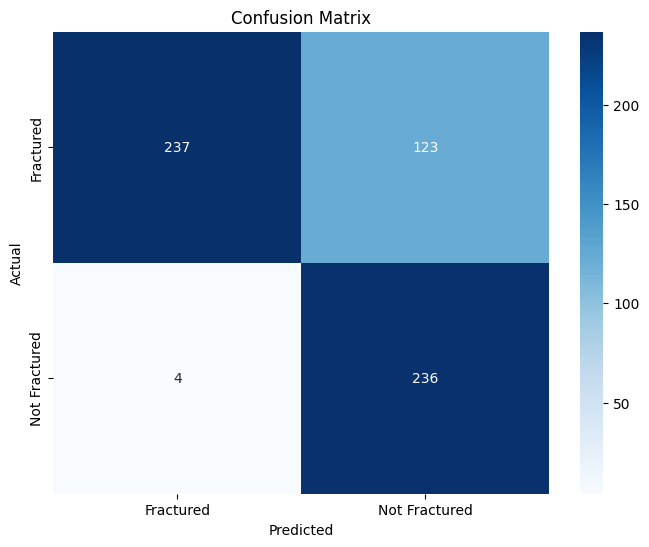

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fractured', 'Not Fractured'],
            yticklabels=['Fractured', 'Not Fractured'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

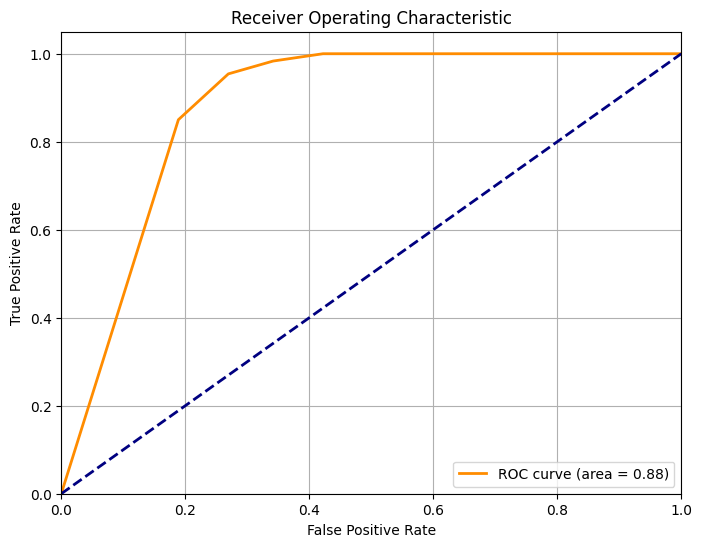

In [14]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
import joblib

# Function to save the model and preprocessing info
def save_model(knn_model, output_dir="models"):
    """Save the trained KNN model"""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save KNN model
    joblib.dump(knn_model, os.path.join(output_dir, "knn_model.pkl"))
    
    # Save model info
    model_info = {
        "img_size": IMG_SIZE,
        "best_k": 5,
        "accuracy": accuracy,
    }
    
    with open(os.path.join(output_dir, "model_info.txt"), "w") as f:
        for key, value in model_info.items():
            f.write(f"{key}: {value}\n")
            
    print(f"Model saved to {output_dir}")

# Save the model
save_model(knn)

print("\nTraining and evaluation completed!")
print(f"Final model accuracy: {accuracy:.4f}")
print(f"Model saved with K={3}")

Model saved to models

Training and evaluation completed!
Final model accuracy: 0.7883
Model saved with K=3
